In [1]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# basic plot settings
import plot_basic

# python implementation of various gradient based methods
import gradient_methods

In [2]:
# load data
# please modified the data folder and save figure folder before run
data_folder = './'
figure_folder = 'Figures/'
f = np.genfromtxt('%sbreast-cancer-wisconsin.data' %data_folder, delimiter=',', missing_values={'?'}, filling_values=0)

In [3]:
# define gradient function for logistic regression
def grad_logistic(prev_pt, X, Y):
    hx = 1.0/(1+np.exp(-np.dot(X, prev_pt)))
    grad = 1.0/Y.shape[0]*np.dot((hx-Y), X)
    return grad

def sgd_grad_logistic(prev_pt, index, X, Y):
    hx = 1.0/(1+np.exp(-np.dot(X, prev_pt)))
    grad = (hx-Y)[index]* X[index, :]
    return grad



In [4]:
# wrappers for gradient methods with the right gradient setup
def nesterov_logistic(x0, X, Y, step_size, T=1000):
    return gradient_methods.nesterov(x0, lambda x: grad_logistic(x, X, Y), step_size, T)

def nesterov_logistic(x0, X, Y, step_size, T=1000):
    return gradient_methods.nesterov(x0, lambda x: grad_logistic(x, X, Y), step_size, T)

def heavy_ball_logistic(x0, X, Y, step_size, gamma, T=1000):
    return gradient_methods.heavy_ball(x0, lambda x: grad_logistic(x, X, Y), step_size, gamma, T)

def fg_logistic(x0, X, Y, step_size, T=1000):
    return gradient_methods.fg(x0, lambda x: grad_logistic(x, X, Y), step_size, T)

def fg_decrease_logistic(x0, X, Y, step_size, alpha, T=1000):
    return gradient_methods.fg_decrease(x0, lambda x: grad_logistic(x, X, Y), step_size, alpha, T)

def sgd_logistic(x0, X, Y, step_size, T=1000, seed = 12345678):
    return gradient_methods.sgd(x0, lambda x, index: sgd_grad_logistic(x, index, X, Y), Y.shape[0], step_size, T, seed = seed)

def sgd_decrease_logistic(x0, X, Y, step_size, alpha, T=1000, seed = 12345678):
    return gradient_methods.sgd_decrease(x0, lambda x, index: sgd_grad_logistic(x, index, X, Y), Y.shape[0], step_size, alpha, T, seed = seed)


In [5]:
# data generation
X = f[:, 1:10]
Y = (f[:, -1]>3)*1

# two sample sets split
X1 = X[:500, :]
Y1 = Y[:500]
X2 = X[:500, :].copy()
Y2 = Y[:500].copy()
X2[499, :] = X[500, :]
Y2[499] = Y[500]
# test data set
TX = X[510:610, :]
TY = Y[510:610]

In [6]:
np.random.seed(12345678)
# initialization
initial = 1.0*np.random.randn(X.shape[1])
# number of iterations
T = 10000
# step size, small -- because we want to run for many iterations 
# It is possible to increase step size if run with many more data points
stepsize = 0.000005
# RUN!
x_nes, y_nes = nesterov_logistic(initial, X1, Y1, stepsize, T)
x_nes2, y_nes2 = nesterov_logistic(initial, X2, Y2, stepsize, T)
x_hb = heavy_ball_logistic(initial, X1, Y1, stepsize, 0.8, T)
x_hb2 = heavy_ball_logistic(initial, X2, Y2, stepsize, 0.8, T)
x_fg = fg_logistic(initial, X1,  Y1, stepsize, T)
x_fg2 = fg_logistic(initial, X2, Y2, stepsize, T)
x_fg_decrease = fg_decrease_logistic(initial, X1,  Y1, stepsize, 0.5, T)
x_fg2_decrease = fg_decrease_logistic(initial, X2, Y2, stepsize, 0.5, T)
x_fg_decrease3 = fg_decrease_logistic(initial, X1,  Y1, stepsize, 0.3, T)
x_fg2_decrease3 = fg_decrease_logistic(initial, X2, Y2, stepsize, 0.3, T)
x_sgd = sgd_logistic(initial, X1,  Y1, stepsize, T, seed = 12345)
x_sgd2 = sgd_logistic(initial, X2, Y2, stepsize, T, seed = 12345)
x_sgd_decrease = sgd_decrease_logistic(initial, X1,  Y1, stepsize, 0.5, T, seed = 12345)
x_sgd2_decrease = sgd_decrease_logistic(initial, X2, Y2, stepsize, 0.5, T, seed = 12345)

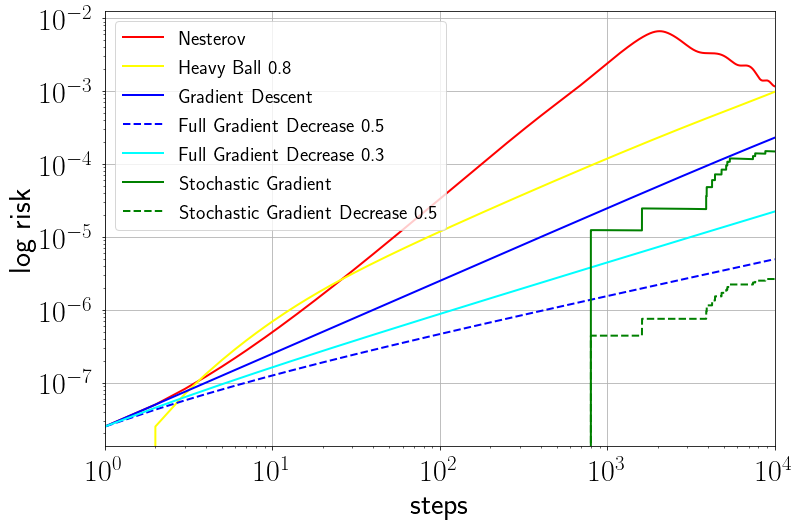

In [7]:
plt.figure(figsize=(12, 8))
plt.loglog(np.linalg.norm(y_nes-y_nes2, axis=1), 'r', label='Nesterov', linewidth=2.0)
plt.loglog(np.linalg.norm(x_hb-x_hb2, axis=1), 'yellow', label='Heavy Ball 0.8', linewidth=2.0)
plt.loglog(np.linalg.norm(x_fg-x_fg2, axis=1), 'b', label='Gradient Descent', linewidth=2.0)
plt.loglog(np.linalg.norm(x_fg_decrease-x_fg2_decrease, axis=1), 'b--', label='Full Gradient Decrease 0.5', linewidth=2.0)
plt.loglog(np.linalg.norm(x_fg_decrease3-x_fg2_decrease3, axis=1), 'cyan', label='Full Gradient Decrease 0.3', linewidth=2.0)

plt.loglog(np.linalg.norm(x_sgd-x_sgd2, axis=1), 'g', label='Stochastic Gradient', linewidth=2.0)
plt.loglog(np.linalg.norm(x_sgd_decrease-x_sgd2_decrease, axis=1), 'g--', label='Stochastic Gradient Decrease 0.5', linewidth=2.0)
plt.legend(loc='upper left', fontsize=20)
plt.xlim(1, 10000)
plt.xlabel("steps")
plt.ylabel("log risk")
plt.grid(True)

plt.savefig('%sstability_scaling_breastdata_all_algorithms.pdf'%figure_folder)
plt.savefig('%sstability_scaling_breastdata_all_algorithms.png'%figure_folder, transparent=True)
plt.show()


## Now use repeated subsamples to estimate stability

In [8]:
# with repeats
# number of repeats
repeats = 50
T = 10000

initial = 1.0*np.random.randn(9)
stepsize = 0.000005
diff_nes = np.zeros((repeats, T))
diff_hb = np.zeros((repeats, T))
diff_fg = np.zeros((repeats, T))
diff_fg_decrease = np.zeros((repeats, T))
diff_fg_decrease3 = np.zeros((repeats, T))
diff_sgd = np.zeros((repeats, T))
diff_sgd_decrease = np.zeros((repeats, T))
for i in range(repeats):
    X1 = X[:500, :]
    Y1 = Y[:500]
    X2 = X[:500, :].copy()
    Y2 = Y[:500].copy()
    X2[499, :] = X[500+i, :]
    Y2[499] = Y[500+i]
    x_nes, y_nes = nesterov_logistic(initial, X1, Y1, stepsize, T)
    x_nes2, y_nes2 = nesterov_logistic(initial, X2, Y2, stepsize, T)

    x_hb = heavy_ball_logistic(initial, X1, Y1, stepsize, 0.8, T)
    x_hb2 = heavy_ball_logistic(initial, X2, Y2, stepsize, 0.8, T)


    x_fg = fg_logistic(initial, X1,  Y1, stepsize, T)
    x_fg2 = fg_logistic(initial, X2, Y2, stepsize, T)


    x_fg_decrease = fg_decrease_logistic(initial, X1,  Y1, stepsize, 0.5, T)
    x_fg2_decrease = fg_decrease_logistic(initial, X2, Y2, stepsize, 0.5, T)

    x_fg_decrease3 = fg_decrease_logistic(initial, X1,  Y1, stepsize, 0.3, T)
    x_fg2_decrease3 = fg_decrease_logistic(initial, X2, Y2, stepsize, 0.3, T)

    x_sgd = sgd_logistic(initial, X1, Y1, stepsize, T, seed = 12345+i)
    x_sgd2 = sgd_logistic(initial, X2, Y2, stepsize, T, seed = 12345+i)

    x_sgd_decrease = sgd_decrease_logistic(initial, X1,  Y1, stepsize, 0.5, T, seed = 12345+i)
    x_sgd2_decrease = sgd_decrease_logistic(initial, X2, Y2, stepsize, 0.5, T, seed = 12345+i)

    
    diff_nes[i, :] = np.linalg.norm(y_nes-y_nes2, axis=1)
    diff_hb[i, :] = np.linalg.norm(x_hb-x_hb2, axis=1)
    diff_fg[i, :] = np.linalg.norm(x_fg-x_fg2, axis=1)
    diff_fg_decrease[i, :] = np.linalg.norm(x_fg_decrease-x_fg2_decrease, axis=1)
    diff_fg_decrease3[i, :] = np.linalg.norm(x_fg_decrease3-x_fg2_decrease3, axis=1)
    diff_sgd[i, :] = np.linalg.norm(x_sgd-x_sgd2, axis=1)
    diff_sgd_decrease[i, :] = np.linalg.norm(x_sgd_decrease-x_sgd2_decrease, axis=1)

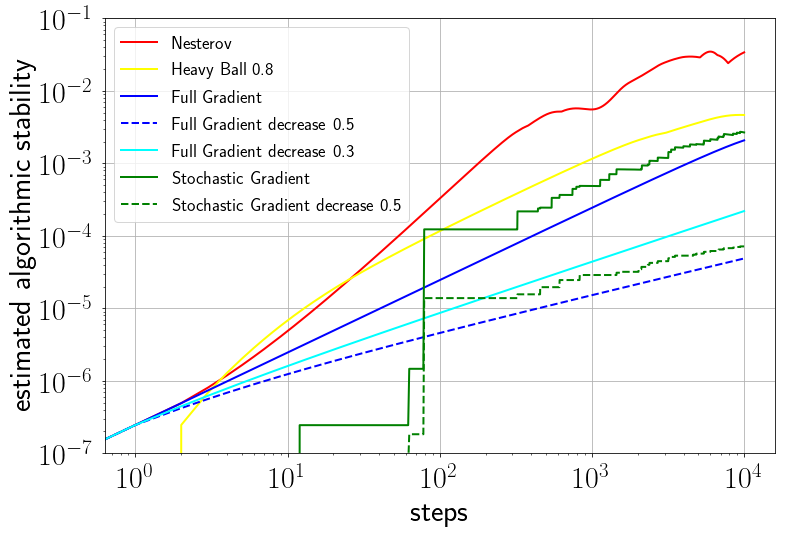

In [9]:
plt.figure(figsize=(12, 8))
plt.loglog(np.max(diff_nes, 0), 'r', label='Nesterov', linewidth=2.0)
plt.loglog(np.max(diff_hb, 0), 'yellow', label='Heavy Ball 0.8', linewidth=2.0)
plt.loglog(np.max(diff_fg, 0), 'b', label='Full Gradient', linewidth=2.0)
plt.loglog(np.max(diff_fg_decrease, 0), 'b--', label='Full Gradient decrease 0.5', linewidth=2.0)
plt.loglog(np.max(diff_fg_decrease3, 0), 'cyan', label='Full Gradient decrease 0.3', linewidth=2.0)

plt.loglog(np.max(diff_sgd, 0), 'g', label='Stochastic Gradient', linewidth=2.0)
plt.loglog(np.max(diff_sgd_decrease, 0), 'g--', label='Stochastic Gradient decrease 0.5', linewidth=2.0)
plt.legend(loc='upper left', fontsize=18)
plt.ylim(1e-7, 1e-1)
plt.xlabel("steps")
plt.ylabel("estimated algorithmic stability")
plt.grid(True)

plt.savefig('%sstability_scaling_50repeats_breastdata_all_algorithms.pdf' %figure_folder)
plt.savefig('%sstability_scaling_50repeats_breastdata_all_algorithms.png' %figure_folder, transparent=True)


plt.show()